## 内容说明

1. 离线加载 VLADs 。**注意**：在规范的流程中，应该是接收到图片，计算 vlad，然后进行后续的步骤。简便起见，在不影响搜索时间对比的情况下，将图片转化 vlad 的过程省略掉，直接在 vlad 上进行操作。
2. 每个图片/vlad到来时，连同之前的 10 幅图片/vlad一起，组成 seqVLAD，作为一个 node，添加到 HNSW 中。对比之前所有的 seqVLAD，找到近似最近邻。暂定为回环点，将相似性值保存起来，以备 PR curve 画图
3. 速度记录：随着历史图片的增多，搜索时间的变化趋势。横坐标是历史图片数量，纵坐标是搜索花费时间。

In [20]:
import numpy as np
import pickle
from numpy.linalg import norm
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import time
import hnswlib
import itertools

### 1. 离线加载 VLADs

In [3]:
vlads_file="newcollege/2_VLADs.pickle"

with open(vlads_file, 'rb') as f:
    VLADs = pickle.load(f)

### 2. 渐增式的构造 HNSW，对每个 query image，搜索近似最近邻

当图片/vlad 来了之后，跟前边 9 个 vlad （共计 10 个）组合出 seqvlad，作为一个 node，逐步添加构造 HNSW，并且搜索最近邻，选出最小的一个（idx, min_value）,留着画 PR 曲线用。

**首先初始化 HNSW 框架**

In [17]:
# init HNSW 
dim = 10 * len(VLADs[0])
num_elements = len(VLADs)

In [269]:
# 生成一个索引对象，指定所在空间维度和度量，可选度量包括 l2, ip, cosine
p = hnswlib.Index(space='l2', dim=dim)

In [270]:
# 依据具体的数据点，初始化索引
# 这里是指定可以存储的最多元素数目
# ef_construction 对应动态列表长度
# M 对应每个新节点创建的连边数目
p.init_index(max_elements=num_elements, ef_construction=100, M=64)
p.set_ef(100)

**开始逐步构造 HNSW 并进行最近邻搜索**

In [271]:
image_num = len(VLADs)
matches = np.nan * np.ones([image_num, 2])

timing = []

for index, vlad in enumerate(VLADs):   
    print('index: ', index)
    
    # construction start from index=19 
    if index >= 19:
        
        # add node 10 frames earlier
        vlad_seq_add = VLADs[index-19:index-9]
        node_add = np.array(list(itertools.chain.from_iterable(vlad_seq_add)), dtype='float32')
        p.add_items(node_add, index-10)
 
        # detection start from index=100
        if index >= 100:     
            
            vlad_seq = VLADs[index-9:index+1]
            node = np.array(list(itertools.chain.from_iterable(vlad_seq)), dtype='float32')
            
            # start timing
            t1 = time.time()
            
            # 给定 query，返回搜索结果
            # 返回的 indices 和 distances 都是 np.array
            indice, distance = p.knn_query(node, k=1)

            # end timing
            t2 = time.time()
            timing.append([index, t2-t1])

            matches[index, 0] = int(indice)
            matches[index, 1] = int(distance)   



index:  0
index:  1
index:  2
index:  3
index:  4
index:  5
index:  6
index:  7
index:  8
index:  9
index:  10
index:  11
index:  12
index:  13
index:  14
index:  15
index:  16
index:  17
index:  18
index:  19
index:  20
index:  21
index:  22
index:  23
index:  24
index:  25
index:  26
index:  27
index:  28
index:  29
index:  30
index:  31
index:  32
index:  33
index:  34
index:  35
index:  36
index:  37
index:  38
index:  39
index:  40
index:  41
index:  42
index:  43
index:  44
index:  45
index:  46
index:  47
index:  48
index:  49
index:  50
index:  51
index:  52
index:  53
index:  54
index:  55
index:  56
index:  57
index:  58
index:  59
index:  60
index:  61
index:  62
index:  63
index:  64
index:  65
index:  66
index:  67
index:  68
index:  69
index:  70
index:  71
index:  72
index:  73
index:  74
index:  75
index:  76
index:  77
index:  78
index:  79
index:  80
index:  81
index:  82
index:  83
index:  84
index:  85
index:  86
index:  87
index:  88
index:  89
index:  90
index:  9

In [272]:
matches

array([[ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       ...,
       [ 14.,  17.],
       [ 15.,  17.],
       [109.,  17.]])

In [80]:
matches_file = "newcollege/3_matches(hnsw).pickle"

with open(matches_file, 'wb') as f:
    pickle.dump(matches, f)

In [273]:
matches[:,1] = matches[:,1] / np.nanmax(matches[:,1])
matches

array([[         nan,          nan],
       [         nan,          nan],
       [         nan,          nan],
       ...,
       [ 14.        ,   0.89473684],
       [ 15.        ,   0.89473684],
       [109.        ,   0.89473684]])

In [226]:
matches_norm_file = "newcollege/3_matches_norm(hnsw).pickle"

with open(matches_norm_file, 'wb') as f:
    pickle.dump(matches, f)

In [299]:
timing_file = "newcollege/5_timing(hnsw).pickle"

with open(timing_file, 'wb') as f:
    pickle.dump(np.array(timing), f)

### 4. Evaluation the matches by PR curve

In [146]:
# load GT matrix
groundtruthPath = 'newcollege/NewCollegeGroundTruth.mat'
groundtruthMat = loadmat(groundtruthPath)
groundtruthMat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Apr 14 16:55:26 2008',
 '__version__': '1.0',
 '__globals__': [],
 'truth': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [147]:
# extract right view
groundtruthMat = groundtruthMat['truth'][::2,::2]
groundtruthMat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [274]:
# 上述 gt 中还是存在一行中连续多列为 1，即一幅图片还可能与多幅邻近的图片匹配，在计算 positive 时不能直接累加，否则 recall 会很低
gt_loop = np.count_nonzero(np.sum(groundtruthMat, 1))
pr = []
row = matches.shape[0]

for mu in np.arange(0, 1, 0.01):
    idx = np.copy(matches[:, 0])  # The LARGER the score, the WEAKER the match.
    idx[matches[:, 1] > mu] = np.nan  # remove the weakest matches

    loopMat = np.zeros((row, row))
    for i in range(row):
        if not np.isnan(idx[i]):
            loopMat[i, int(idx[i])] = 1

    p_loop = np.sum(loopMat)
    TP = np.sum(loopMat * groundtruthMat)
    if p_loop != 0:
        pre = TP / p_loop
        rec = TP / gt_loop
        pr.append([pre, rec])

pr = np.array(pr)

36


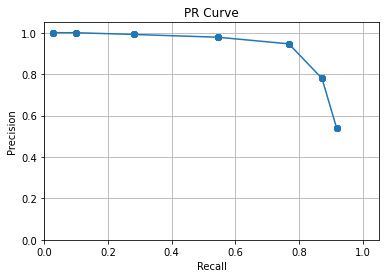

In [275]:
# plt.subplots() is recommended by matplotlib
fig, ax = plt.subplots()
ax.plot(pr[:, 1], pr[:, 0], '-o')
print(len(pr))
ax.set_title('PR Curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()
plt.axis([0, 1.05, 0, 1.05])
plt.show()

In [276]:
PR_curve_file = "newcollege/4_PR_curve(hnsw).pickle"

with open(PR_curve_file, 'wb') as f:
    pickle.dump(pr, f)

### 5. Timing of seq search

In [279]:
timing_file = "newcollege/5_timing(hnsw).pickle"

with open(timing_file, 'rb') as f:
    timing = pickle.load(f)

In [280]:
timing_array = np.array(timing)

In [281]:
timing_array

array([[1.00000000e+02, 4.59671021e-04],
       [1.01000000e+02, 4.71353531e-04],
       [1.02000000e+02, 4.42743301e-04],
       ...,
       [1.07000000e+03, 3.58009338e-03],
       [1.07100000e+03, 3.42655182e-03],
       [1.07200000e+03, 3.33046913e-03]])

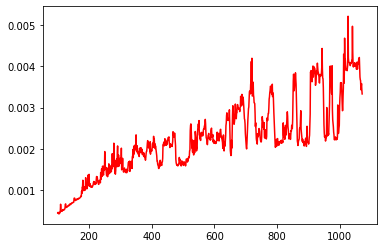

In [282]:
plt.plot(timing_array[:,0], timing_array[:,1], 'r-')

### 6. 对比两种搜索方式

In [284]:
# Comparison of PR curve 
with open('newcollege/4_PR_curve.pickle', 'rb') as f1:          
    pr1 = pickle.load(f1)
          
with open('newcollege/4_PR_curve(hnsw).pickle', 'rb') as f2:
    pr2 = pickle.load(f2)        

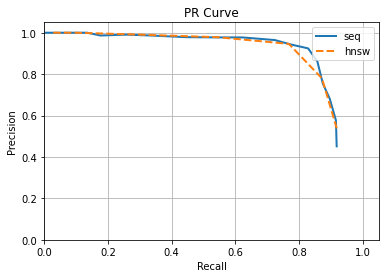

In [306]:
plt.plot(pr1[:, 1], pr1[:, 0], '-', linewidth=2.0)
plt.plot(pr2[:, 1], pr2[:, 0], '--', linewidth=2.0)

plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1.05, 0, 1.05])
plt.grid()
plt.legend(['seq', 'hnsw'], loc="upper right")
plt.show()

In [300]:
# Comparison of search time
with open('newcollege/5_timing.pickle', 'rb') as f1:          
    timing1 = pickle.load(f1)
          
with open('newcollege/5_timing(hnsw).pickle', 'rb') as f2:
    timing2 = pickle.load(f2)        

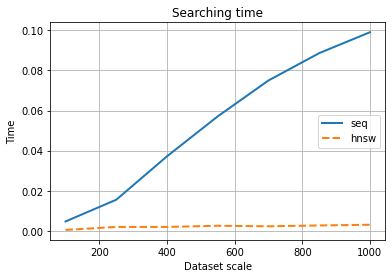

In [307]:
plt.plot(timing1[::150, 0], timing1[::150, 1], '-', linewidth=2.0)
plt.plot(timing2[::150, 0], timing2[::150, 1], '--', linewidth=2.0)

plt.title('Searching time')
plt.xlabel('Dataset scale')
plt.ylabel('Time')
plt.grid()
plt.legend(['seq', 'hnsw'], loc="right")
plt.show()